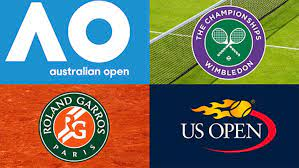

### Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

In [ ]:
conda install -c conda-forge cufflinks-py

In [ ]:
import cufflinks as cf

# For Notebooks
init_notebook_mode(connected=True)

# For offline use
cf.go_offline()

### Importing Dataset

Here, we have three files in the dataset namely: Match.csv, Player.csv and Stats.csv. Since we only want to focus on 
predicting the match winner based on the statistics from the previou matches we will mostly use the Stats.csv file for 
the purpose of modeling.

In [ ]:
match= pd.read_csv('Match.csv')
player= pd.read_csv('Player.csv')
stats= pd.read_csv('Stats.csv')

In [ ]:
match.head()

In [ ]:
player.head()

In [ ]:
stats.head()

In [ ]:
match.info()

In [ ]:
player.info()

In [ ]:
stats.info()

In [ ]:
#to check for missing values in the dataset 
plt.figure(figsize=(15,4))
sns.heatmap(data=stats.isnull(),yticklabels=False, cmap='crest')

#### Merging the three datasets together

In [ ]:
#merging datasets 
#player datasets = 53k entries 
#stats datset = 20k entries
#match datset = 10k entries 
#we will only consider those who data is in stats and may or may not be in player 

In [ ]:
merge_match_stats = pd.merge(match,stats, how='inner',on='match_id')

In [ ]:
#merge_match_stats.groupby('match_id').mean()

In [ ]:
overall_merge= pd.merge(merge_match_stats,player,how='inner', on='player_id')

In [ ]:
overall_merge.info()

In [ ]:
overall_merge.nunique()

In [ ]:
#to check for missing values in the dataset 
plt.figure(figsize=(15,4))
sns.heatmap(data=overall_merge.isnull(),yticklabels=False, cmap='crest')

The are a lot of missing data points in columns 4 and 5 as well as in the avg odds and max odds columns. We can drop these for the purpose of our analysis.  

However, the points(pts) column can be treated with Imputer function to fill in the missing values. 

In [ ]:
#Imputing missing values 
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
imputer.fit(overall_merge.iloc[:,10].values.reshape(-1,1))
overall_merge.iloc[:,10]  = imputer.transform(overall_merge.iloc[:,10].values.reshape(-1,1))


In [ ]:
#to check for missing values in the dataset 
plt.figure(figsize=(15,4))
sns.heatmap(data=overall_merge.isnull(),yticklabels=False, cmap='crest')

Selecting columns relevant for our analysis and dropping the following:
1. avg_minutes_game     
2. avg_seconds_point     
3. avg_minutes_set
4. sets
5. 1
6. 2
7. 3
8. 4
9. 5
10. avg_odds (most data missing)
11. max_odds (most data missing)

In [ ]:
#only considering the relevant variables and dropping the remaining columns
overall_merge=overall_merge.iloc[:,[0,1,6,7,8,9,10,11,12,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]

In [ ]:
overall_merge.info()

In [ ]:
#Re-arranging the columns
overall_merge= overall_merge.iloc[:,[0,5,20,21,22,23,7,1,2,3,4,6,9,10,11,12,13,14,15,16,17,18,19,8]]

In [ ]:
overall_merge

Now some analysis questions to answer


#### 1. Find the top 10 players over the years across all grand slam tournaments based on their average rankings and which country do they hail from?

In [ ]:
top_10 =overall_merge.set_index(['name','country']).groupby(by=['name', 'country']).mean().sort_values('rank').head(10)
top_10

Therefore, if we look across the data from 2000 to 2019, we see that on an average, the top 10 ranked players:
Roger Federer, Rafael Nadal, Andre Agassi, Pete Sampras, Yevgeny Kafelnikov, Yevgeny Kafelnikov, Novak Djokovic,
Andy Roddick,Patrick Rafter, David Ferrer and Andy Murray

#### 2. Find the number of right or left hand players in the dataset

In [ ]:
overall_merge['hand'].unique()

There are 3 categories of hand information- right-handed, left-handed and unknown

In [ ]:
plt.figure(figsize=(10, 4))

hand_info= overall_merge[['player_id','hand']].groupby('hand').count().sort_values('player_id', ascending=False).plot(kind='bar')

for bar in hand_info.patches:
    
    hand_info.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0,4),
                   textcoords='offset points')

plt.title('Number of players - Split across which hand they play with')
    

#### 3. Find the longest match ever played in the 20 years across the four grand slams?

In [ ]:
long_match=overall_merge[['match_id','match_minutes','tournament']].sort_values('match_minutes', ascending=False)
long_match.groupby('tournament').max()

Thus, the longest matches across all four grand slams were played in 2019, with Wimbeldon witnessing a 
match go as long as 665 minutes 

#### 4. Number of aces, double faults, break points faced and saved across tournaments in last 20 years 

In [ ]:
year_list =overall_merge['year'].unique().tolist()

In [ ]:
#Aces
aces= overall_merge.set_index(['year','tournament','name']).sort_values('year')
aces= aces[(aces['round']=='The Final')& (aces['winner']==True)]
aces.reset_index()

plt.figure(figsize=(20,5))
sns.lineplot(x='year', y='aces', data= aces, hue='tournament')
plt.title('Number of Aces by players across all tournaments in the last 20 years')
plt.xticks(year_list, labels=None, rotation=0)
plt.show()

#Double faults
df= overall_merge.set_index(['year','tournament','name']).sort_values('year')
df= df[(df['round']=='The Final')& (df['winner']==True)]
df.reset_index()

plt.figure(figsize=(20,5))
sns.lineplot(x='year', y='dbl_faults', data= aces, hue='tournament')
plt.title('Number of Double Faults by players across all tournaments in the last 20 years')
plt.xticks(year_list, labels=None, rotation=0)
plt.show()

#Break Points Faced and saved on average across the tournaments
bpf= overall_merge.set_index(['year','tournament','name']).sort_values('year')
bpf= bpf[(bpf['round']=='The Final')& (bpf['winner']==True)]
bpf.reset_index(inplace=True)

ax1 = sns.set_style(style=None, rc=None)
fig, ax1 = plt.subplots(figsize=(20,5))
sns.lineplot(data = bpf['bp_faced'] ,marker='o', ax=ax1)
ax2 = ax1.twinx()
sns.barplot(data = bpf, x='year', y='bp_saved', alpha=0.5, ax=ax2)
plt.title('Number of Break points faced and saved on average by players across all tournaments in the last 20 years')
plt.show()

From here, we can clearly show that Wimbledon has the highest number of aces across the years witha peak in 2009.

#### 5. To see correlations between different variables with winning. 

In [ ]:
#overall
overall_corr= overall_merge.corr()
sns.heatmap(overall_corr, cmap='crest')

In [ ]:
#Correlation between aces and winning
pivot_aces= overall_merge.pivot_table(index='winner', columns='year', values='aces')
sns.heatmap(pivot_aces,  cmap='crest')

Strong correlation exists between winning and aces

In [ ]:
#Correlation between double faults and winning
pivot_dbf= overall_merge.pivot_table(index='winner', columns='year', values='dbl_faults')
sns.heatmap(pivot_dbf,  cmap='crest')

#### 6. Trajectory of best player over the years, which is Roger Federer
Here, we showcase his trajectory through the number of matches he won over the years, the escalation in world ranking
in all 4 grand slam tournaments

Some basic statistics on him 

In [ ]:
overall_merge[(overall_merge['name']=='Roger Federer')].groupby(['year','tournament']).count()

Number of matches played= 413
Country= Switzerland
Age=41
Playing hand= Right
Number of Grandslam tournaments played= 76

In [ ]:
rg_win= overall_merge[(overall_merge['name']=='Roger Federer') & (overall_merge['winner']== True)].sort_values('year')
rg_win.groupby(['year']).match_id.count().iplot(title='Matches won by Roger Federer over the last 20 years',
            xTitle='Years', yTitle='Matches Won')

In [ ]:
plt.figure(figsize=(15,5))
rank= overall_merge[(overall_merge['name']=='Roger Federer')].sort_values('year').groupby(['year','tournament']).mean()
rank = rank.reset_index()
sns.lineplot(x='year', y='rank', data=rank, hue='tournament')

year_list= list(overall_merge['year'].unique())
plt.xticks(year_list, labels=None, rotation=45)
plt.ylim(60,0)
plt.show()



### MODELING 

### Encoding categorical data

Before we built a supervised classification model using the merged data, we need to encode the categorical data. Here, our independent variables that are categorical are: Name, Hand, Country, Round and Tournament. Fo the purpose of our modeling, we will only encode Hand and tournmament since the other categories will not be to helpful in our modeling. We will also encode the dependent variable - Winner as well.

In [ ]:
overall_merge.info()

In [ ]:
overall_merge=overall_merge.iloc[:,[3,6,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23]]

In [ ]:
overall_merge

In [ ]:
#Defining our independent and dependent variables
X= overall_merge.iloc[:,:-1].values
y=overall_merge.iloc[:,-1].values

In [ ]:
#Encoding independent variables - hand and tournament
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
col_trans= ColumnTransformer(transformers=[('encoder', OneHotEncoder(),[0,2])],remainder='passthrough')
X= np.array(col_trans.fit_transform(X))

In [ ]:
#Encoding dependent variable- winner
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
y= le.fit_transform(y)

### Splitting the data into training set and test set 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Feature Scaling- To ensure all out models perform better 

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc= StandardScaler()

In [ ]:
X_train[:,11:]= sc.fit_transform(X_train[:,11:])
X_test[:,11:]= sc.transform(X_test[:,11:])

In [ ]:
#Imputing values in X_train and X_test to remove null values 
from sklearn.impute import SimpleImputer
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train  = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

In [ ]:
np.any(np.isnan(X_train))

In [ ]:
np.all(np.isfinite(X_train))

In [ ]:
np.all(np.isnan(X_train))

In [ ]:
np.all(np.isfinite(X_train))

In [ ]:
np.any(np.isnan(y_train))

In [ ]:
print(np.isnan(X_train))

In [ ]:
np.all(np.isfinite(y_train))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_class= LogisticRegression()


In [ ]:
log_class.fit(X_train, y_train)

#### Predicting the test result

In [ ]:
y_pred_logr = log_class.predict(X_test)

In [ ]:
y_pred_logr

#### Evaluating the test result

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
cr_log= classification_report(y_pred_logr,y_test)
cm_log= confusion_matrix(y_pred_logr,y_test)
print(cr_log)
print(cm_log)
accuracy_score(y_pred_logr,y_test)


So, the logistic regression function is 86% accurate in predicting the test results 

## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn= KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(X_train,y_train)

#### Predicting the test result

In [ ]:
y_pred_knn = knn.predict(X_test)

#### Evaluating the test result

In [ ]:

cr_knn= classification_report(y_pred_knn,y_test)
cm_knn= confusion_matrix(y_pred_knn,y_test)
print(cr_knn)
print(cm_knn)
accuracy_score(y_pred_knn,y_test)

So, the KNN Classifier algorithm is 64% accurate in predicting the test results 

## Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc= SVC(kernel='linear')

In [ ]:
svc.fit(X_train,y_train)

#### Predicting the test result

In [ ]:
y_pred_svc = svc.predict(X_test)

#### Evaluating the test result

In [ ]:

cr_svc= classification_report(y_pred_svc,y_test)
cm_svc= confusion_matrix(y_pred_svc,y_test)
print(cr_svc)
print(cm_svc)
accuracy_score(y_pred_svc,y_test)

So, the Support Vector Classifier algorithm is 90% accurate in predicting the test results 

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb= GaussianNB()
nb.fit(X_train,y_train)

#### Predicting the test result

In [ ]:
y_pred_nb = nb.predict(X_test)

#### Evaluating the test result

In [ ]:
cr_nb= classification_report(y_pred_nb,y_test)
cm_nb= confusion_matrix(y_pred_nb,y_test)
print(cr_nb)
print(cm_nb)
accuracy_score(y_pred_nb,y_test)

So, the Naive Bayes algorithm is 81% accurate in predicting the test results 

## Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc= DecisionTreeClassifier()
dtc.fit(X_train,y_train)

#### Predicting the test result

In [ ]:
y_pred_dtc = dtc.predict(X_test)

#### Evaluating the test result

In [ ]:
cr_dtc= classification_report(y_pred_dtc,y_test)
cm_dtc= confusion_matrix(y_pred_dtc,y_test)
print(cr_dtc)
print(cm_dtc)
accuracy_score(y_pred_dtc,y_test)

So, the decision tree algorithm is 83% accurate in predicting the test results 

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
rfc.fit(X_train,y_train)

#### Predicting the test result

In [ ]:
y_pred_rfc = rfc.predict(X_test)

#### Evaluating the test result

In [ ]:
cr_rfc= classification_report(y_pred_rfc,y_test)
cm_rfc= confusion_matrix(y_pred_rfc,y_test)
print(cr_rfc)
print(cm_rfc)
accuracy_score(y_pred_rfc,y_test)

So, the random forest algorithm is 80% accurate in predicting the test results 

### Conclusion

Thus, out of all the classification models, the <b>logistic regression </b>algorithm predicts the test results most accurately. 